## <font color='darkblue'>Motivation</font>
([article source](https://towardsdatascience.com/introduction-to-one-way-anova-a-test-to-compare-the-means-between-more-than-two-groups-a656cb53b19c)) <font size='3ptx'>**The Outcomes of Different Groups Look Different, but are they Statistically Different?**</font>

**A [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) is useful to find out whether there is a significant difference between two groups.** However, a t-test cannot be used to compare between three or more independent groups.

For example, if you are a product developer, you might want to know whether the change in the percentage of cotton used in the synthetic fiber will result in an increase in the tensile strength of the fiber.

To find out, you can conduct a completely randomized experiment with five levels of cotton content and replicate the experiment five times representing five trials. The data might look like the following table:

In [1]:
import pandas as pd
import numpy as np

In [2]:
exp_df = pd.DataFrame(
    [
        [15, 7, 12, 14, 19, 7],
        [20, 7, 17, 19, 25, 10],
        [25,15, 12, 19, 22, 11],
        [30,11, 18, 18, 19, 15],
        [35, 9, 18, 18, 23, 11]
    ],
    columns = ['cotton_weight_percent', 'observation_1', 'observation_2', 'observation_3', 'observation_4', 'observation_5']
)
exp_df

,cotton_weight_percent,observation_1,observation_2,observation_3,observation_4,observation_5
0,15,7,12,14,19,7
1,20,7,17,19,25,10
2,25,15,12,19,22,11
3,30,11,18,18,19,15
4,35,9,18,18,23,11


By looking at the table alone, it is difficult to know whether there are **<font color='darkblue'>statistically significant differences</font>** between the means of these 5 levels of cotton content. Since there are more than 2 groups being compared, a t-test cannot be used in this case.

**Is there a way that you can determine whether any of these means are statistically different from each other and produces meaningful outputs like below?**

Pairs of levels of cotton content that are not statistically different:
* (15, 20)
* (15, 25)
* (15, 30)
* (20, 30)
* (25, 35)
* (30, 35)

Pairs of levels of cotton content that are statistically different:
* (15, 35)
* (20, 25)
* (20, 35)
* (25, 30)

That is when [**one-way ANOVA**](https://en.wikipedia.org/wiki/One-way_analysis_of_variance) (one-way analysis of variance) comes in handy.

## <font color='darkblue'>What is One-Way ANOVA?</font>
The one-way ANOVA compares the means of the groups you are interested in and determines whether any of those means are statistically different from each other. A one-way ANOVA has one independent variable while a two-way ANOVA has two independent variables.

**Since there is only one independent variable in our problem, which is tensile strength, we will use a one-way ANOVA.** To perform a one-way ANOVA in Python, we will install and use [**statsmodels**](https://www.statsmodels.org/stable/index.html) package:

In [4]:
#!pip install statsmodels

### <font color='darkgreen'>Create Data</font>
We will create data that is shown in the introduction:

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.graphics.gofplots import qqplot
import warnings
from IPython.display import display, Math, Latex, Markdown

In [8]:
warnings.filterwarnings("ignore")

cotton_weight_percent = [15, 15, 15, 15, 15, 20, 20, 20, 20, 20, 25, 25, 25, 25,
                        25, 30, 30, 30, 30, 30, 35, 35, 35, 35, 35]
observations = [7, 7, 15, 11, 9, 12, 16, 12, 18, 18, 14, 19, 19, 18, 18, 19, 25,
              22, 19, 23, 7, 10, 11, 15, 11]

df = pd.DataFrame(
    {"observations": observations, "cotton_weight_percent": cotton_weight_percent}
)
df.sample(n=5)

,observations,cotton_weight_percent
0,7,15
20,7,35
2,15,15
24,11,35
21,10,35


Nice! The data is set up. Now we are ready to use the one-way ANOVA test.

### <font color='darkgreen'>Compare the Means Between Different Groups</font>
**We start with testing whether the means of some levels of cotton content are statistically different.**
* **<font color='red'>Null hypothesis</font>**: There is no difference in means
* **<font color='green'>Alternate hypothesis</font>**: The means are not all equal

Since [anova-lm](https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html) requires one or more fitted linear models, we start with fitting the <font color='darkblue'>**Ordinary Least Squares**</font> (OLS) model to our data then use it as an argument for [anova-lm](https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html).

In [9]:
model = ols("observations ~ C(cotton_weight_percent)", df).fit()
res = anova_lm(model, typ=1)
res

,df,sum_sq,mean_sq,F,PR(>F)
C(cotton_weight_percent),4.0,475.2,118.80,14.962217,0.000008
Residual,20.0,158.8,7.94,NaN,NaN


The F-statistic of the model is 14.962217. **The p-value of the model is 8e-06**.

**Since the p-value is less than the significance level of 0.05, there is enough evidence to claim that some of the means of different levels of cotton content are statistically different.**

Even though we know some of the means are statistically different overall, which specific two levels of cotton content are different? That is when [**Tukey’s HSD**](https://en.wikipedia.org/wiki/Tukey%27s_range_test) (<font color='brown'>Honest Significant Difference</font>) comes in handy.

### <font color='darkgreen'>Compare Each Pair of Means Using Tukey’s HSD</font>
[**Tukey’s HSD**](https://en.wikipedia.org/wiki/Tukey%27s_range_test) finds out which specific groups’ means are different. The test compares all possible pairs of means. Let’s use [**MultiComparision**](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.html) and its [turkeyhsd()](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.tukeyhsd.html#statsmodels.sandbox.stats.multicomp.MultiComparison.tukeyhsd) method to test for multiple comparisons.

In [10]:
comparison = MultiComparison(df["observations"], df["cotton_weight_percent"])
comparison_results = comparison.tukeyhsd()
comparison_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
15,20,5.4,0.0463,0.0668,10.7332,True
15,25,7.8,0.0024,2.4668,13.1332,True
15,30,11.8,0.001,6.4668,17.1332,True
15,35,1.0,0.9,-4.3332,6.3332,False
20,25,2.4,0.6493,-2.9332,7.7332,False
20,30,6.4,0.014,1.0668,11.7332,True
20,35,-4.4,0.1379,-9.7332,0.9332,False
25,30,4.0,0.2043,-1.3332,9.3332,False
25,35,-6.8,0.0085,-12.1332,-1.4668,True
30,35,-10.8,0.001,-16.1332,-5.4668,True


Explanation of the table above:
* `group1` is compared to `group2`
* **`meandiff`** : the mean difference between `group1` and `group2`
* **`p-adj`** : how likely `group1` and `group2` to have the same means
* **`lower` and `upper`** : `lower` and `upper` bound of the confidence interval.
* **`reject`** : If it is True , the null hypothesis is rejected. There is enough evidence to claim that the means of the two levels of cotton being compared are significantly different.

Pairs of levels of cotton content that are statistically different:
* (15, 35)
* (20, 25)
* (20, 35)
* (25, 30)

To understand the results better, let’s look at the plots that visualize significant differences with one confidence interval per group.

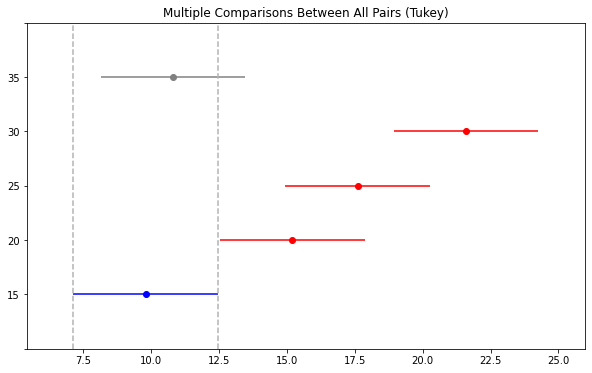

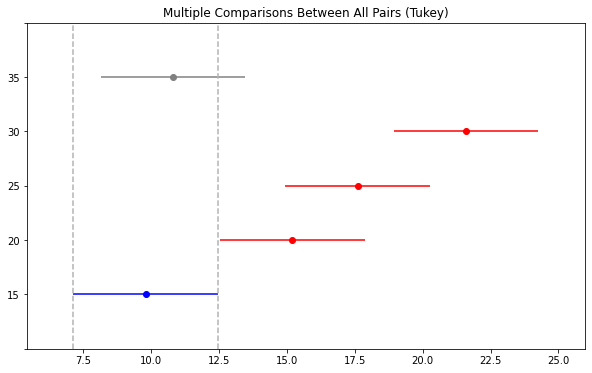

In [11]:
comparison_results.plot_simultaneous(comparison_name=15)

### <font color='darkgreen'>Check Model Assumptions</font>
**ANOVA assumes that each sample was drawn from a normally distributed population.** To use ANOVA at all, we need to make sure that this assumption is met. To test for normality, we will create a Q-Q plot of residuals. The Q-Q plot plots quantiles of the data versus quantiles of a normal distribution.

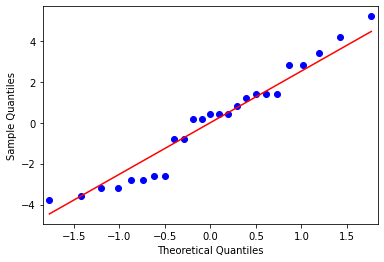

In [12]:
residuals = model.resid
plot = qqplot(residuals, line="s")

Since the data points fall along a straight diagonal line in a Q-Q plot, the dataset is likely to follow a normal distribution. Thus, the data satisfies ANOVA’s assumption of normality.

## <font color='darkblue'>Conclusion</font>
**Congratulations! You have just learned how to use one-way ANOVA to compare the means of three or more independent groups. No matter how good your data is, if you don’t have a good testing technique, you won’t be able to extract meaningful insights from your data.**

With ANOVA, you will be able to determine if differences in mean values between three or more groups are by chance or if they are indeed significantly different. Eventually, **it will help you decide if it is beneficial to choose one group over others.**